# Phase 2: Trajectory Prediction with Auxiliary Depth Estimation

# 🧭 Introduction

"""
Welcome to **Phase 2** of the DLAV Projec! 🚗💨

In this phase, you'll work with a more challenging dataset that includes:
- RGB **camera images**
- Ground-truth **depth maps**
- Ground-truth **semantic segmentation** labels

Your goal is still to predict the **future trajectory** of the self-driving car (SDC), but you now have more tools at your disposal! 🎯

Here, we provide an example where **depth estimation** is used as an auxiliary task to improve trajectory prediction.

However, you're **free to explore** other auxiliary tasks (e.g., using semantic labels), different loss functions, data augmentations, or better architectures! 💡

This notebook will walk you through loading the dataset, building a model, training with and without the auxiliary task, and visualizing results.
"""

In [ ]:
# Install gdown to handle Google Drive file download
!pip install -q gdown

import gdown
import zipfile

download_url = f"https://drive.google.com/uc?id=1YkGwaxBKNiYL2nq--cB6WMmYGzRmRKVr"
output_zip = "dlav_train.zip"
gdown.download(download_url, output_zip, quiet=False)  # Downloads the file to your drive
with zipfile.ZipFile(output_zip, 'r') as zip_ref:  # Extracts the downloaded zip file
    zip_ref.extractall(".")

download_url = "https://drive.google.com/uc?id=1wtmT_vH9mMUNOwrNOMFP6WFw6e8rbOdu"
output_zip = "dlav_val.zip"
gdown.download(download_url, output_zip, quiet=False)
with zipfile.ZipFile(output_zip, 'r') as zip_ref:
    zip_ref.extractall(".")

download_url = "https://drive.google.com/uc?id=1G9xGE7s-Ikvvc2-LZTUyuzhWAlNdLTLV"
output_zip = "dlav_test_public.zip"
gdown.download(download_url, output_zip, quiet=False)
with zipfile.ZipFile(output_zip, 'r') as zip_ref:
    zip_ref.extractall(".")

Downloading...
From (original): https://drive.google.com/uc?id=1YkGwaxBKNiYL2nq--cB6WMmYGzRmRKVr
From (redirected): https://drive.google.com/uc?id=1YkGwaxBKNiYL2nq--cB6WMmYGzRmRKVr&confirm=t&uuid=8beb7eb0-3fcf-485e-b044-45459bb55d0e
To: /content/dlav_train.zip
100%|██████████| 439M/439M [00:07<00:00, 55.3MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1wtmT_vH9mMUNOwrNOMFP6WFw6e8rbOdu
From (redirected): https://drive.google.com/uc?id=1wtmT_vH9mMUNOwrNOMFP6WFw6e8rbOdu&confirm=t&uuid=d9929cb5-5ea9-4b94-b8b2-b7fc4aea6f84
To: /content/dlav_val.zip
100%|██████████| 87.8M/87.8M [00:01<00:00, 49.8MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1G9xGE7s-Ikvvc2-LZTUyuzhWAlNdLTLV
From (redirected): https://drive.google.com/uc?id=1G9xGE7s-Ikvvc2-LZTUyuzhWAlNdLTLV&confirm=t&uuid=278982aa-2585-4418-8568-c5b63c264a25
To: /content/dlav_test_public.zip
100%|██████████| 86.6M/86.6M [00:01<00:00, 49.3MB/s]


Now lets load the data and visualize the first few examples to see what we are dealing with!

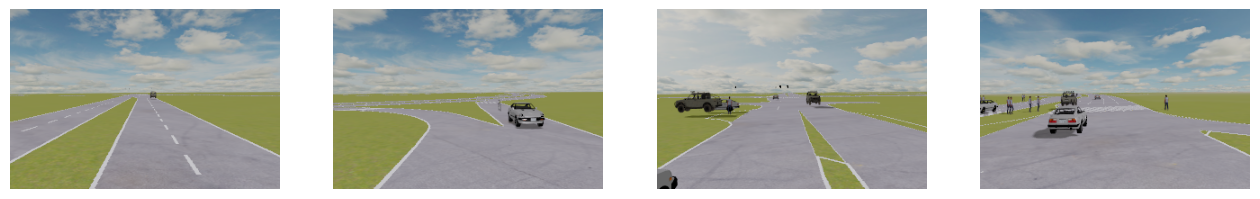

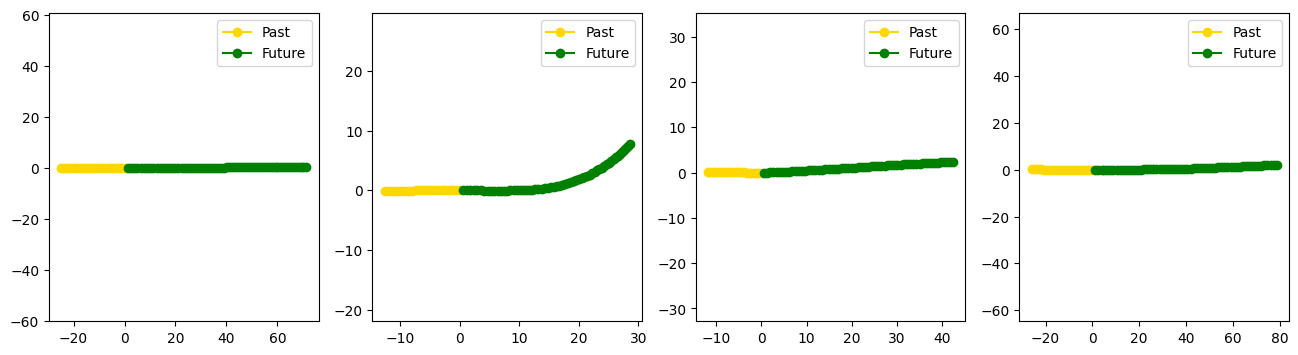

In [ ]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import random

k = 4
# load the data
data = []
for i in random.choices(np.arange(1000), k=k):
    with open(f"train/{i}.pkl", "rb") as f:
        data.append(pickle.load(f))

# plot the camera view of current step for the k examples
fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
for i in range(k):
    axis[i].imshow(data[i]["camera"])
    axis[i].axis("off")
plt.show()

# plot the past and future trajectory of the vehicle
fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
for i in range(k):
    axis[i].plot(data[i]["sdc_history_feature"][:, 0], data[i]["sdc_history_feature"][:, 1], "o-", color="gold", label="Past")
    axis[i].plot(data[i]["sdc_future_feature"][:, 0], data[i]["sdc_future_feature"][:, 1], "o-", color="green", label="Future")
    axis[i].legend()
    axis[i].axis("equal")
plt.show()

## 📂 The Dataset

We are now working with a richer dataset that includes not just images and trajectories,
but also **depth maps** (and semantic segmentation labels, though unused in this example).

The data is stored in `.pkl` files and each file contains:
- `camera`: RGB image (shape: H x W x 3)
- `sdc_history_feature`: the past trajectory of the car
- `sdc_future_feature`: the future trajectory to predict
- `depth`: ground truth depth map (shape: H x W x 1)

We'll define a `DrivingDataset` class to load and return these tensors in a format our model can work with.

In [166]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset, default_collate
from PIL import Image
import pickle
from collections import Counter
import torchvision.transforms.functional as TF
import torch.nn.functional as F

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

class DrivingDataset(Dataset):
    def __init__(self, file_list, augment=False, test=False):
        self.samples = file_list
        self.test = test
        self.cmd2idx = {'forward': 0, 'left': 1, 'right': 2}

        self.img_size = (224, 224)
        self.aux_size = (56, 56)  # Perception head output size
        if augment:
            self.transform = transforms.Compose([
                transforms.Resize(self.img_size),
                transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.1),
                transforms.RandomAffine(0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
                transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
                transforms.ToTensor(),
            ])
        else:
            self.transform = transforms.Compose([
                transforms.Resize(self.img_size),
                transforms.ToTensor(),
            ])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        with open(self.samples[idx], 'rb') as f:
            data = pickle.load(f)

        # --- Image ---
        camera = Image.fromarray(data['camera'].astype(np.uint8))
        camera = self.transform(camera)  # (3, 224, 224)

        # --- Motion ---
        pos_xyh = data['sdc_history_feature'][:, :3]
        vel = np.zeros_like(pos_xyh)
        vel[1:] = pos_xyh[1:] - pos_xyh[:-1]
        acc = np.zeros_like(pos_xyh)
        acc[1:] = vel[1:] - vel[:-1]
        timestep = np.linspace(0, 1, 21).reshape(-1, 1)
        ego_flag = np.ones((21, 1))
        history = np.concatenate([pos_xyh, vel, acc, timestep, ego_flag], axis=1)

        cmd_idx = self.cmd2idx[data['driving_command']]

        # --- Semantic & Depth ---
        sem_raw = data['semantic_label'].astype(np.int64)  # (200, 300)
        sem = torch.from_numpy(sem_raw)
        sem_resized = TF.resize(sem.unsqueeze(0), self.aux_size, interpolation=transforms.InterpolationMode.NEAREST).squeeze(0)

        depth = data['depth'].astype(np.float32)  # (200, 300, 1)
        depth = torch.from_numpy(depth).permute(2, 0, 1)  # (1, 200, 300)
        depth = TF.resize(depth, self.aux_size, interpolation=transforms.InterpolationMode.BILINEAR)

        # --- Object Presence Masks (resized to aux resolution) ---
        def resize_mask(class_id):
            mask = (sem == class_id).float().unsqueeze(0)
            return TF.resize(mask, self.aux_size, interpolation=transforms.InterpolationMode.NEAREST).squeeze(0)

        car_mask = resize_mask(1)             # CAR
        lane_mask = resize_mask(12)           # LANE_LINE
        traffic_light_mask = resize_mask(9)   # TRAFFIC_LIGHT
        truck_mask = resize_mask(2)           # TRUCK

        semantic_mask = torch.stack([
            car_mask,
            lane_mask,
            traffic_light_mask,
            truck_mask
        ], dim=0)  # (4, 56, 56)

        if self.test:
            return {
                'camera': camera,
                'history': torch.FloatTensor(history),
                'command': torch.tensor(cmd_idx).long(),
                'depth': depth,
                'semantic': sem_resized,
                'car_mask': car_mask,                       # (56, 56)
                'lane_line_mask': lane_mask,                # (56, 56)
                'traffic_light_mask': traffic_light_mask,   # (56, 56)
                'truck_mask': truck_mask,                   # (56, 56)
                'semantic_mask': semantic_mask
            }

        # --- Future Trajectory ---
        future = data['sdc_future_feature'][:, :3]

        return {
            'camera': camera,                           # (3, 224, 224)
            'history': torch.FloatTensor(history),      # (21, 10)
            'future': torch.FloatTensor(future),        # (60, 3)
            'command': torch.tensor(cmd_idx).long(),
            'depth': depth,                             # (1, 56, 56)
            'semantic': sem_resized,                    # (56, 56)
            'car_mask': car_mask,                       # (56, 56)
            'lane_line_mask': lane_mask,                # (56, 56)
            'traffic_light_mask': traffic_light_mask,   # (56, 56)
            'truck_mask': truck_mask,                   # (56, 56)
            'semantic_mask': semantic_mask              # (4, 56, 56)
        }

## 🧠 The Model: Trajectory + Depth Prediction

We've extended our trajectory prediction model to optionally include a **depth estimation decoder**.

Why?
- Predicting depth helps the model **learn richer visual features** from the camera input.
- This acts as a form of **multi-task learning**, where learning to estimate depth reinforces scene understanding, ultimately leading to better trajectory predictions.
- This can be especially useful in complex environments with occlusions or sharp turns.

The model has:
- A CNN backbone to extract features from the image
- An MLP to process historical trajectory features
- A trajectory decoder to predict future coordinates
- (Optionally) A depth decoder to predict dense depth maps

This auxiliary task is enabled by setting `use_depth_aux=True`.

In [167]:
import torch
import torch.nn as nn
from torchvision.models import resnet34, resnet18


class TransformerMotionEncoder(nn.Module):
    def __init__(self, input_dim=10, emb_dim=128, num_layers=2, num_heads=4):
        super().__init__()
        self.embedding = nn.Linear(input_dim, emb_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=emb_dim, nhead=num_heads, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.pool = nn.AdaptiveAvgPool1d(1)

    def forward(self, x):
        x = self.embedding(x)
        x = self.encoder(x)
        x = x.transpose(1, 2)
        x = self.pool(x).squeeze(2)
        return x


class CASPStylePlanner(nn.Module):
    def __init__(self, hidden_dim=256, future_len=60, use_aux_fusion=False):
        super().__init__()
        self.future_len = future_len
        self.use_aux_fusion = use_aux_fusion

        # === CNN Towers ===
        resnet_plan = resnet34(pretrained=True)
        self.plan_encoder = nn.Sequential(*list(resnet_plan.children())[:-2])  # (B, 512, 7, 7)

        resnet_percep = resnet34(pretrained=True)
        self.percep_encoder = nn.Sequential(*list(resnet_percep.children())[:-2])  # (B, 512, 7, 7)

        self.plan_fc = nn.Linear(512 * 7 * 7, hidden_dim)

        # === Motion & Command ===
        self.motion_encoder = TransformerMotionEncoder(input_dim=11, emb_dim=128)
        self.motion_proj = nn.Linear(128, hidden_dim)
        self.cmd_embedding = nn.Embedding(3, 32)

        # === Auxiliary Heads ===
        self.depth_head = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(256), nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=3, padding=1)
        )

        self.seg_head = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(256), nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64, 14, 3, padding=1)
        )

        self.semantic_mask_encoder = nn.Sequential(
          nn.Conv2d(4, 32, kernel_size=3, padding=1),
          nn.ReLU(),
          nn.Conv2d(32, 64, kernel_size=3, padding=1),
          nn.ReLU(),
          nn.AdaptiveAvgPool2d((7, 7)),
          nn.Flatten(),
          nn.Linear(64 * 7 * 7, 128),
          nn.ReLU()
        )

        # === Feature Projections for Fusion ===
        self.depth_proj = nn.Sequential(
            nn.AdaptiveAvgPool2d((7, 7)),
            nn.Flatten(),
            nn.Linear(7 * 7, 64),
            nn.ReLU()
        )

        self.seg_proj = nn.Sequential(
            nn.AdaptiveAvgPool2d((7, 7)),
            nn.Flatten(),
            nn.Linear(14 * 7 * 7, 128),
            nn.ReLU()
        )

        self.attn_heads = nn.ModuleDict({
            'car': nn.Linear(512, 1),
            'lane_line': nn.Linear(512, 1),
            'traffic_light': nn.Linear(512, 1),
            'truck': nn.Linear(512, 1),
        })

        # === Fusion Layer ===
        base_fusion_dim = hidden_dim * 2 + 32      # 544
        max_aux_dim = 64 + 128 + 128               # 192
        self.fusion_input_dim = base_fusion_dim + max_aux_dim  # 736

        self.fusion_fc = nn.Sequential(
            nn.Linear(self.fusion_input_dim, hidden_dim),
            nn.ReLU()
        )

        # === GRU Decoder ===
        self.decoder_gru = nn.GRUCell(input_size=hidden_dim + 3, hidden_size=hidden_dim)
        self.pred_head = nn.Linear(hidden_dim, 3)

        self.scheduled_sampling_prob = 1.0

    def forward(self, camera, history, command, depth=None, semantic_mask=None, gt_future=None,
                decode_len=None, return_aux=True, use_aux=False, force_aux=False):
        B = camera.size(0)
        device = camera.device
        decode_len = decode_len or self.future_len

        # === Planning Tower ===
        x_plan_feat = self.plan_encoder(camera)
        x_plan = self.plan_fc(x_plan_feat.view(B, -1))

        # === Perception Features ===
        x_percep_feat = self.percep_encoder(camera)

        # === Motion and Command ===
        x_hist = self.motion_encoder(history)
        x_hist = self.motion_proj(x_hist)
        x_cmd = self.cmd_embedding(command)

        # === Optional Aux Fusion ===
        # Always predict for supervision
        depth_out = self.depth_head(x_percep_feat)
        seg_out = self.seg_head(x_percep_feat)

        # Conditional fusion
        aux_feats = []
        if force_aux or self.use_aux_fusion or use_aux:
            if depth is not None:
                depth_feat = self.depth_proj(depth)  # (B, 1, H, W) → (B, 64)
            else:
                # fall back to predicted depth if no depth input
                predicted_depth = self.depth_head(x_percep_feat)
                depth_feat = self.depth_proj(predicted_depth)
            seg_feat = self.seg_proj(seg_out)

            if semantic_mask is not None:
                sem_mask_feat = self.semantic_mask_encoder(semantic_mask)  # Output: (B, 128)
                aux_feats = [depth_feat, seg_feat, sem_mask_feat]
            else:
                aux_feats = [depth_feat, seg_feat]


        # === Fusion ===
        if aux_feats:
            fusion_input = torch.cat([x_plan, x_hist, x_cmd, *aux_feats], dim=-1)
        else:
            padding = torch.zeros(B, 192+128, device=device)
            fusion_input = torch.cat([x_plan, x_hist, x_cmd, padding], dim=-1)

        fused = self.fusion_fc(fusion_input)

        # === Decoder ===
        h = fused
        last_pred = torch.zeros(B, 3, device=device)
        outputs = []

        sampling = self.training and gt_future is not None
        if sampling:
            use_gt = (torch.rand(B, device=device) < self.scheduled_sampling_prob)

        for t in range(decode_len):
            if sampling and t > 0:
                last_pred = torch.where(use_gt.view(-1, 1), gt_future[:, t-1, :], last_pred)

            inp = torch.cat([fused, last_pred], dim=-1)
            h = self.decoder_gru(inp, h)
            delta = self.pred_head(h)
            last_pred = last_pred + delta
            outputs.append(last_pred.unsqueeze(1))

        traj_out = torch.cat(outputs, dim=1)

        if return_aux:
            global_feat = F.adaptive_avg_pool2d(x_percep_feat, (1, 1)).view(B, -1)  # (B, 512)
            attn_preds = {k: head(global_feat) for k, head in self.attn_heads.items()}
            return traj_out, depth_out, seg_out, attn_preds
        else:
            return traj_out

## 🏋️ Training with Auxiliary Loss

The training loop is similar to Phase 1 — except now, if enabled, we also compute a loss on the predicted **depth map**.

We define:
- `trajectory_loss` as standard MSE between predicted and true future trajectory
- `depth_loss` as L1 loss between predicted and ground truth depth

Total loss = `trajectory_loss + lambda * depth_loss`

This helps guide the model to learn better representations from visual input. The weight `lambda` is a hyperparameter you can tune!


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm

# --------------------
# DWA (Dynamic Weight Averaging)
# --------------------
class DWAWeightBalancer:
    def __init__(self, loss_names, temp=1.0):
        self.loss_names = loss_names
        self.temp = temp
        self.history = {name: [1.0, 1.0] for name in loss_names}  # [t-2, t-1]

    def update(self, current_losses):
        updated_weights = {}

        for name in self.loss_names:
            l_prev2, l_prev1 = self.history[name]
            ratio = torch.tensor(l_prev1 / (l_prev2 + 1e-8))  # avoid div by 0
            weight = len(self.loss_names) * torch.exp(ratio / self.temp)
            updated_weights[name] = weight.item()

        # Normalize to sum to 1
        total = sum(updated_weights.values())
        normalized = {k: v / total for k, v in updated_weights.items()}

        # Update history for next epoch
        for name in self.loss_names:
            self.history[name][0] = self.history[name][1]
            self.history[name][1] = current_losses.get(name, 1.0)

        return normalized

# --------------------
# Loss Function
# --------------------
class PlanningLaplaceLossSequential(nn.Module):
    def __init__(self, fixed_b=1.2, weights=None):
        super().__init__()
        self.fixed_b = fixed_b

        self.loss_names = ['laplace', 'heading', 'velocity', 'smoothness', 'curvature']
        self.weights = weights or {
            'laplace': 1.2,
            'heading': 0.8,
            'velocity': 0.1,
            'smoothness': 0.05,
            'curvature': 0.5,
        }

    def heading_to_vec(self, theta):
        return torch.stack([torch.cos(theta), torch.sin(theta)], dim=-1)

    def laplace_nll(self, pred, gt, scale):
        if not torch.is_tensor(scale):
            scale = torch.tensor(scale, device=pred.device, dtype=pred.dtype)
        error = torch.abs(pred - gt)
        return torch.mean(torch.log(2 * scale) + error / scale)

    def forward(self, pred_seq, gt_seq, update_dwa=False, curved_mask=None):
        """
        Args:
            pred_seq: (B, 60, 3)
            gt_seq: (B, 60, 3)
            update_dwa: bool — call with True *once per epoch* to update weights
        """
        losses = {}

        # Position NLL
        losses['laplace'] = self.laplace_nll(pred_seq[..., :2], gt_seq[..., :2], self.fixed_b)

        # Heading direction
        pred_vec = self.heading_to_vec(pred_seq[..., 2])
        gt_vec = self.heading_to_vec(gt_seq[..., 2])
        losses['heading'] = F.mse_loss(pred_vec, gt_vec)

        # Velocity and smoothness
        pred_vel = pred_seq[:, 1:, :2] - pred_seq[:, :-1, :2]
        gt_vel = gt_seq[:, 1:, :2] - gt_seq[:, :-1, :2]
        losses['velocity'] = F.mse_loss(pred_vel, gt_vel)

        pred_acc = pred_vel[:, 1:] - pred_vel[:, :-1]
        losses['smoothness'] = pred_acc.norm(dim=2).mean()

        # Curvature (heading rate)
        pred_dtheta = pred_seq[:, 1:, 2] - pred_seq[:, :-1, 2]
        gt_dtheta = gt_seq[:, 1:, 2] - gt_seq[:, :-1, 2]
        losses['curvature'] = F.mse_loss(pred_dtheta, gt_dtheta)

        total = sum(self.weights[k] * losses[k] for k in self.loss_names)
        return total, losses

# --------------------
# Curved Mask (for Curved ADE/FDE)
# --------------------
def get_curved_mask(future, threshold=0.02):
    dh = future[:, 1:, 2] - future[:, :-1, 2]  # heading differences
    curvature = dh.abs().mean(dim=1)
    return curvature > threshold

# --------------------
# Training Function
# --------------------
def train(model, train_loader, val_loader, optimizer, scheduler, num_epochs=100,
          save_path='best_model.pt', early_stop_patience=20):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    planning_loss_fn = PlanningLaplaceLossSequential(fixed_b=1.2)
    aux_dwa = DWAWeightBalancer(['traj', 'depth', 'seg'])

    best_ade = float('inf')
    patience = 0
    λ_lane, λ_attn = 0.4, 0.3  # fixed

    for epoch in range(num_epochs):
        model.train()
        pbar = tqdm(train_loader, desc=f"[Train Epoch {epoch+1}]")
        aux_losses_epoch = {'traj': [], 'depth': [], 'seg': []}

        use_aux = epoch >= 65  # ⬅️ Phase transition for auxiliary fusion

        for batch in pbar:
            camera = batch["camera"].to(device)
            history = batch["history"].to(device)
            future = batch["future"].to(device)
            command = batch["command"].to(device)

            depth_gt = batch["depth"].to(device)
            seg_gt = batch["semantic"].to(device)
            lane_mask = batch["lane_line_mask"].to(device)
            semantic_mask = batch["semantic_mask"].to(device)

            # Optional object presence masks
            attn_obj_masks = {
                obj: batch[f"{obj}_mask"].to(device)
                for obj in ['car', 'traffic_light', 'truck', 'lane_line']
            }

            optimizer.zero_grad()
            decode_len = min(60, 20 + epoch * 2)

            # === Forward ===
            out = model(
                camera, history, command,
                semantic_mask=semantic_mask,
                depth=depth_gt,
                gt_future=future,
                decode_len=decode_len,
                return_aux=True,
                force_aux=use_aux
            )

            if use_aux:
                traj_pred, depth_pred, seg_pred, attn_preds = out
            else:
                traj_pred, depth_pred, seg_pred,_ = out
                attn_preds = {}

            # === Primary loss ===
            curved_mask = get_curved_mask(future[:, :decode_len], threshold=0.01)
            traj_loss, loss_dict = planning_loss_fn(traj_pred, future[:, :decode_len], curved_mask=curved_mask)

            # === Aux losses ===
            depth_loss = F.l1_loss(depth_pred, depth_gt)
            seg_loss = F.cross_entropy(seg_pred, seg_gt)
            lane_pred = seg_pred[:, 12]  # class 12 is lane line
            lane_loss = F.binary_cross_entropy_with_logits(lane_pred, lane_mask)

            # === Attention Presence Loss ===
            attn_loss = 0.0
            if use_aux:
                for obj_name, mask in attn_obj_masks.items():
                    has_object = (mask.view(mask.size(0), -1).max(dim=1).values > 0.5).float()
                    pred_logit = attn_preds[obj_name].squeeze(1)
                    attn_loss += F.binary_cross_entropy_with_logits(pred_logit, has_object)

            # === Log aux losses
            aux_losses_epoch['traj'].append(traj_loss.item())
            aux_losses_epoch['depth'].append(depth_loss.item())
            aux_losses_epoch['seg'].append(seg_loss.item())

            # === λ weights via DWA
            if epoch < 1:
                λ_plan, λ_depth, λ_seg = 1.2, 0.2, 0.2
            elif epoch < 80:
                weights = aux_dwa.update({k: np.mean(v) for k, v in aux_losses_epoch.items()})
                λ_plan = 1.2
                λ_depth = weights['depth'] * 0.4
                λ_seg = weights['seg'] * 0.3
            else:
                λ_plan, λ_depth, λ_seg = 1.2, 0.1, 0.1

            # === Total loss
            if epoch < 25:
                total_loss = traj_loss
            elif epoch < 45:
                total_loss = λ_plan * traj_loss + λ_depth * depth_loss + λ_seg * seg_loss
            else:
                total_loss = (
                    λ_plan * traj_loss +
                    λ_depth * depth_loss +
                    λ_seg * seg_loss +
                    λ_lane * lane_loss +
                    λ_attn * attn_loss
                )

            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            optimizer.step()

            # === Logging
            loss_dict.update({
                "depth": depth_loss.item(),
                "seg": seg_loss.item(),
                "lane": lane_loss.item(),
                "attn": attn_loss.item() if use_aux else 0.0,
                "λ_plan": λ_plan,
                "λ_depth": λ_depth,
                "λ_seg": λ_seg,
                "total": total_loss.item()
            })
            pbar.set_postfix({k: f"{v:.3f}" for k, v in loss_dict.items()})

        # === Scheduled sampling decay
        model.scheduled_sampling_prob *= 0.97
        model.scheduled_sampling_prob = max(0.1, model.scheduled_sampling_prob)

        # === Validation ===
        model.eval()
        ade_scores, fde_scores = [], []

        with torch.no_grad():
            for batch in tqdm(val_loader, desc="[Validation]"):
                camera = batch["camera"].to(device)
                history = batch["history"].to(device)
                future = batch["future"].to(device)
                command = batch["command"].to(device)

                depth = batch.get("depth", None)
                semantic = batch.get("semantic", None)
                semantic_mask = batch.get("semantic_mask", None)

                # Send to device if they exist
                if depth is not None:
                    depth = depth.to(device)
                if semantic is not None:
                    semantic = semantic.to(device)
                if semantic_mask is not None:
                    semantic_mask = semantic_mask.to(device)

                traj_pred = model(
                    camera,
                    history,
                    command,
                    semantic_mask=semantic_mask,
                    depth=depth,
                    return_aux=False,
                    force_aux=use_aux  # Ensure fusion is on if needed
                )
                ade = ((traj_pred[..., :2] - future[..., :2]) ** 2).sum(-1).sqrt().mean()
                fde = ((traj_pred[:, -1, :2] - future[:, -1, :2]) ** 2).sum(-1).sqrt().mean()

                ade_scores.append(ade.item())
                fde_scores.append(fde.item())

        avg_ade = np.mean(ade_scores)
        avg_fde = np.mean(fde_scores)

        scheduler.step(avg_ade)

        print(f"[Epoch {epoch+1}] ADE: {avg_ade:.4f} | FDE: {avg_fde:.4f}")
        print(f"λ weights — plan: {λ_plan:.3f}, depth: {λ_depth:.3f}, seg: {λ_seg:.3f}")

        if avg_ade < best_ade:
            best_ade = avg_ade
            patience = 0
            torch.save(model.state_dict(), save_path)
            print(f"New best model saved (ADE: {best_ade:.4f})")
        else:
            patience += 0
            if patience >= early_stop_patience:
                print("Early stopping triggered.")
                break


In [ ]:
import torch.optim as optim
from torch.utils.data import DataLoader
import os

train_data_dir = "train"
val_data_dir = "val"

train_files = [os.path.join(train_data_dir, f) for f in os.listdir(train_data_dir) if f.endswith('.pkl')]
val_files = [os.path.join(val_data_dir, f) for f in os.listdir(val_data_dir) if f.endswith('.pkl')]

all_futures = []
for file in train_files:
    with open(file, 'rb') as f:
        data = pickle.load(f)
        all_futures.append(data['sdc_future_feature'][:, :3])  # only x, y

all_futures = np.concatenate(all_futures, axis=0)  # shape: (N*60, 3)

train_dataset = DrivingDataset(train_files, augment=True, test=False)
val_dataset = DrivingDataset(val_files, augment=False, test=False)

train_loader = DataLoader(train_dataset, batch_size=16, num_workers=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, num_workers=2)

model = CASPStylePlanner()

optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=15, T_mult=1)

train(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=200,
    save_path='best_model.pt'
)

[Validation]: 100%|██████████| 63/63 [00:02<00:00, 24.72it/s]


[Epoch 1] ADE: 6.0407 | FDE: 21.0879
🔁 λ weights — plan: 1.200, depth: 0.200, seg: 0.200
✅ New best model saved (ADE: 6.0407)


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 25.18it/s]


[Epoch 2] ADE: 4.3595 | FDE: 14.5320
🔁 λ weights — plan: 1.200, depth: 0.133, seg: 0.100
✅ New best model saved (ADE: 4.3595)


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 24.74it/s]


[Epoch 3] ADE: 6.1626 | FDE: 17.8079
🔁 λ weights — plan: 1.200, depth: 0.133, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 25.74it/s]


[Epoch 4] ADE: 9.7385 | FDE: 23.8216
🔁 λ weights — plan: 1.200, depth: 0.133, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 25.18it/s]


[Epoch 5] ADE: 3.7428 | FDE: 11.8178
🔁 λ weights — plan: 1.200, depth: 0.133, seg: 0.100
✅ New best model saved (ADE: 3.7428)


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 25.67it/s]


[Epoch 6] ADE: 3.1889 | FDE: 8.6610
🔁 λ weights — plan: 1.200, depth: 0.133, seg: 0.100
✅ New best model saved (ADE: 3.1889)


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 24.91it/s]


[Epoch 7] ADE: 3.1666 | FDE: 8.8416
🔁 λ weights — plan: 1.200, depth: 0.133, seg: 0.100
✅ New best model saved (ADE: 3.1666)


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 24.92it/s]


[Epoch 8] ADE: 5.0159 | FDE: 11.0616
🔁 λ weights — plan: 1.200, depth: 0.133, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 25.91it/s]


[Epoch 9] ADE: 2.9016 | FDE: 8.0295
🔁 λ weights — plan: 1.200, depth: 0.133, seg: 0.100
✅ New best model saved (ADE: 2.9016)


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 25.54it/s]


[Epoch 10] ADE: 2.9821 | FDE: 7.7782
🔁 λ weights — plan: 1.200, depth: 0.133, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 26.25it/s]


[Epoch 11] ADE: 3.0523 | FDE: 7.7817
🔁 λ weights — plan: 1.200, depth: 0.133, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 24.42it/s]


[Epoch 12] ADE: 3.7845 | FDE: 8.9819
🔁 λ weights — plan: 1.200, depth: 0.133, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 25.90it/s]


[Epoch 13] ADE: 3.2372 | FDE: 7.8420
🔁 λ weights — plan: 1.200, depth: 0.133, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 24.65it/s]


[Epoch 14] ADE: 2.9865 | FDE: 7.9082
🔁 λ weights — plan: 1.200, depth: 0.133, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 25.67it/s]


[Epoch 15] ADE: 2.7661 | FDE: 7.4855
🔁 λ weights — plan: 1.200, depth: 0.133, seg: 0.100
✅ New best model saved (ADE: 2.7661)


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 24.17it/s]


[Epoch 16] ADE: 2.6505 | FDE: 7.1295
🔁 λ weights — plan: 1.200, depth: 0.133, seg: 0.100
✅ New best model saved (ADE: 2.6505)


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 26.09it/s]


[Epoch 17] ADE: 2.6326 | FDE: 6.8980
🔁 λ weights — plan: 1.200, depth: 0.133, seg: 0.100
✅ New best model saved (ADE: 2.6326)


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 26.00it/s]


[Epoch 18] ADE: 2.7931 | FDE: 7.5103
🔁 λ weights — plan: 1.200, depth: 0.133, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 26.14it/s]


[Epoch 19] ADE: 2.9747 | FDE: 7.2097
🔁 λ weights — plan: 1.200, depth: 0.133, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 25.93it/s]


[Epoch 20] ADE: 2.8318 | FDE: 7.2843
🔁 λ weights — plan: 1.200, depth: 0.133, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 25.77it/s]


[Epoch 21] ADE: 2.8612 | FDE: 7.6188
🔁 λ weights — plan: 1.200, depth: 0.133, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 25.19it/s]


[Epoch 22] ADE: 2.4857 | FDE: 6.7575
🔁 λ weights — plan: 1.200, depth: 0.133, seg: 0.100
✅ New best model saved (ADE: 2.4857)


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 25.89it/s]


[Epoch 23] ADE: 2.8003 | FDE: 7.1824
🔁 λ weights — plan: 1.200, depth: 0.133, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 25.51it/s]


[Epoch 24] ADE: 2.1693 | FDE: 6.0581
🔁 λ weights — plan: 1.200, depth: 0.133, seg: 0.100
✅ New best model saved (ADE: 2.1693)


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 25.44it/s]


[Epoch 25] ADE: 2.1920 | FDE: 6.1430
🔁 λ weights — plan: 1.200, depth: 0.133, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 25.28it/s]


[Epoch 26] ADE: 2.3100 | FDE: 6.1724
🔁 λ weights — plan: 1.200, depth: 0.133, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 25.81it/s]


[Epoch 27] ADE: 2.5455 | FDE: 6.4992
🔁 λ weights — plan: 1.200, depth: 0.133, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 25.80it/s]


[Epoch 28] ADE: 2.3478 | FDE: 6.3141
🔁 λ weights — plan: 1.200, depth: 0.133, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 25.95it/s]


[Epoch 29] ADE: 2.3729 | FDE: 6.3688
🔁 λ weights — plan: 1.200, depth: 0.133, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 25.60it/s]


[Epoch 30] ADE: 2.2068 | FDE: 5.9738
🔁 λ weights — plan: 1.200, depth: 0.133, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 26.11it/s]


[Epoch 31] ADE: 2.4366 | FDE: 6.3097
🔁 λ weights — plan: 1.200, depth: 0.133, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 25.50it/s]


[Epoch 32] ADE: 2.4320 | FDE: 6.3723
🔁 λ weights — plan: 1.200, depth: 0.133, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 25.96it/s]


[Epoch 33] ADE: 2.4581 | FDE: 6.4865
🔁 λ weights — plan: 1.200, depth: 0.133, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 25.76it/s]


[Epoch 34] ADE: 2.0910 | FDE: 5.8819
🔁 λ weights — plan: 1.200, depth: 0.133, seg: 0.100
✅ New best model saved (ADE: 2.0910)


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 25.45it/s]


[Epoch 35] ADE: 2.4556 | FDE: 6.4102
🔁 λ weights — plan: 1.200, depth: 0.133, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 25.80it/s]


[Epoch 36] ADE: 2.0561 | FDE: 5.7729
🔁 λ weights — plan: 1.200, depth: 0.133, seg: 0.100
✅ New best model saved (ADE: 2.0561)


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 25.50it/s]


[Epoch 37] ADE: 2.0393 | FDE: 5.5650
🔁 λ weights — plan: 1.200, depth: 0.133, seg: 0.100
✅ New best model saved (ADE: 2.0393)


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 26.31it/s]


[Epoch 38] ADE: 2.0313 | FDE: 5.7442
🔁 λ weights — plan: 1.200, depth: 0.133, seg: 0.100
✅ New best model saved (ADE: 2.0313)


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 25.41it/s]


[Epoch 39] ADE: 2.0719 | FDE: 5.7629
🔁 λ weights — plan: 1.200, depth: 0.133, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 25.75it/s]


[Epoch 40] ADE: 2.0994 | FDE: 5.8317
🔁 λ weights — plan: 1.200, depth: 0.133, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 25.48it/s]


[Epoch 41] ADE: 2.0119 | FDE: 5.5331
🔁 λ weights — plan: 1.200, depth: 0.133, seg: 0.100
✅ New best model saved (ADE: 2.0119)


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 25.01it/s]


[Epoch 42] ADE: 1.9569 | FDE: 5.4784
🔁 λ weights — plan: 1.200, depth: 0.133, seg: 0.100
✅ New best model saved (ADE: 1.9569)


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 25.67it/s]


[Epoch 43] ADE: 2.0753 | FDE: 5.5918
🔁 λ weights — plan: 1.200, depth: 0.133, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 24.68it/s]


[Epoch 44] ADE: 2.0206 | FDE: 5.5411
🔁 λ weights — plan: 1.200, depth: 0.133, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 23.78it/s]


[Epoch 45] ADE: 1.9533 | FDE: 5.4659
🔁 λ weights — plan: 1.200, depth: 0.133, seg: 0.100
✅ New best model saved (ADE: 1.9533)


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 25.50it/s]


[Epoch 46] ADE: 2.1030 | FDE: 5.7191
🔁 λ weights — plan: 1.200, depth: 0.133, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 25.47it/s]


[Epoch 47] ADE: 1.9798 | FDE: 5.5003
🔁 λ weights — plan: 1.200, depth: 0.133, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 25.68it/s]


[Epoch 48] ADE: 1.9981 | FDE: 5.5175
🔁 λ weights — plan: 1.200, depth: 0.133, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 25.45it/s]


[Epoch 49] ADE: 2.1440 | FDE: 5.7926
🔁 λ weights — plan: 1.200, depth: 0.133, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 24.77it/s]


[Epoch 50] ADE: 1.9328 | FDE: 5.3982
🔁 λ weights — plan: 1.200, depth: 0.133, seg: 0.100
✅ New best model saved (ADE: 1.9328)


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 25.85it/s]


[Epoch 51] ADE: 2.4362 | FDE: 6.2536
🔁 λ weights — plan: 1.200, depth: 0.133, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 24.38it/s]


[Epoch 52] ADE: 2.0695 | FDE: 5.6905
🔁 λ weights — plan: 1.200, depth: 0.133, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 24.81it/s]


[Epoch 53] ADE: 2.0468 | FDE: 5.6068
🔁 λ weights — plan: 1.200, depth: 0.133, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 24.80it/s]


[Epoch 54] ADE: 1.9669 | FDE: 5.5271
🔁 λ weights — plan: 1.200, depth: 0.133, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 25.38it/s]


[Epoch 55] ADE: 1.9975 | FDE: 5.4800
🔁 λ weights — plan: 1.200, depth: 0.133, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 25.43it/s]


[Epoch 56] ADE: 1.9063 | FDE: 5.2065
🔁 λ weights — plan: 1.200, depth: 0.133, seg: 0.100
✅ New best model saved (ADE: 1.9063)


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 25.81it/s]


[Epoch 57] ADE: 1.9889 | FDE: 5.3385
🔁 λ weights — plan: 1.200, depth: 0.133, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 24.69it/s]


[Epoch 58] ADE: 1.8954 | FDE: 5.2437
🔁 λ weights — plan: 1.200, depth: 0.133, seg: 0.100
✅ New best model saved (ADE: 1.8954)


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 25.87it/s]


[Epoch 59] ADE: 1.9861 | FDE: 5.4494
🔁 λ weights — plan: 1.200, depth: 0.133, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 25.48it/s]


[Epoch 60] ADE: 1.8330 | FDE: 5.2080
🔁 λ weights — plan: 1.200, depth: 0.133, seg: 0.100
✅ New best model saved (ADE: 1.8330)


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 24.75it/s]


[Epoch 61] ADE: 1.9251 | FDE: 5.3384
🔁 λ weights — plan: 1.200, depth: 0.133, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 25.64it/s]


[Epoch 62] ADE: 2.0058 | FDE: 5.5182
🔁 λ weights — plan: 1.200, depth: 0.133, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 24.57it/s]


[Epoch 63] ADE: 1.8661 | FDE: 5.0764
🔁 λ weights — plan: 1.200, depth: 0.133, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 26.12it/s]


[Epoch 64] ADE: 1.8683 | FDE: 5.0655
🔁 λ weights — plan: 1.200, depth: 0.133, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 26.13it/s]


[Epoch 65] ADE: 1.8016 | FDE: 5.0093
🔁 λ weights — plan: 1.200, depth: 0.133, seg: 0.100
✅ New best model saved (ADE: 1.8016)


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 24.64it/s]


[Epoch 66] ADE: 1.8183 | FDE: 4.9788
🔁 λ weights — plan: 1.200, depth: 0.133, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 25.28it/s]


[Epoch 67] ADE: 1.8791 | FDE: 5.2240
🔁 λ weights — plan: 1.200, depth: 0.133, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 24.53it/s]


[Epoch 68] ADE: 1.9163 | FDE: 5.0675
🔁 λ weights — plan: 1.200, depth: 0.133, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 23.20it/s]


[Epoch 69] ADE: 1.8048 | FDE: 5.0138
🔁 λ weights — plan: 1.200, depth: 0.133, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 25.25it/s]


[Epoch 70] ADE: 1.8031 | FDE: 4.9083
🔁 λ weights — plan: 1.200, depth: 0.133, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 24.73it/s]


[Epoch 71] ADE: 1.9018 | FDE: 5.2011
🔁 λ weights — plan: 1.200, depth: 0.133, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 25.19it/s]


[Epoch 72] ADE: 1.8281 | FDE: 4.9671
🔁 λ weights — plan: 1.200, depth: 0.133, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 25.11it/s]


[Epoch 73] ADE: 1.9448 | FDE: 5.1959
🔁 λ weights — plan: 1.200, depth: 0.133, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 25.13it/s]


[Epoch 74] ADE: 2.0200 | FDE: 5.1756
🔁 λ weights — plan: 1.200, depth: 0.133, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 25.24it/s]


[Epoch 75] ADE: 1.7571 | FDE: 4.8985
🔁 λ weights — plan: 1.200, depth: 0.133, seg: 0.100
✅ New best model saved (ADE: 1.7571)


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 24.99it/s]


[Epoch 76] ADE: 1.8264 | FDE: 5.0461
🔁 λ weights — plan: 1.200, depth: 0.133, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 24.30it/s]


[Epoch 77] ADE: 2.3657 | FDE: 6.3896
🔁 λ weights — plan: 1.200, depth: 0.133, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 24.89it/s]


[Epoch 78] ADE: 1.7995 | FDE: 4.8613
🔁 λ weights — plan: 1.200, depth: 0.133, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 24.50it/s]


[Epoch 79] ADE: 1.7438 | FDE: 4.9284
🔁 λ weights — plan: 1.200, depth: 0.133, seg: 0.100
✅ New best model saved (ADE: 1.7438)


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 24.63it/s]


[Epoch 80] ADE: 1.7339 | FDE: 4.7517
🔁 λ weights — plan: 1.200, depth: 0.133, seg: 0.100
✅ New best model saved (ADE: 1.7339)


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 25.40it/s]


[Epoch 81] ADE: 1.8228 | FDE: 4.8639
🔁 λ weights — plan: 1.200, depth: 0.100, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 25.83it/s]


[Epoch 82] ADE: 1.7537 | FDE: 4.7890
🔁 λ weights — plan: 1.200, depth: 0.100, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 25.05it/s]


[Epoch 83] ADE: 1.6636 | FDE: 4.6695
🔁 λ weights — plan: 1.200, depth: 0.100, seg: 0.100
✅ New best model saved (ADE: 1.6636)


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 25.24it/s]


[Epoch 84] ADE: 1.7317 | FDE: 4.8843
🔁 λ weights — plan: 1.200, depth: 0.100, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 24.65it/s]


[Epoch 85] ADE: 1.7377 | FDE: 4.7718
🔁 λ weights — plan: 1.200, depth: 0.100, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 24.96it/s]


[Epoch 86] ADE: 1.7727 | FDE: 4.7695
🔁 λ weights — plan: 1.200, depth: 0.100, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 25.26it/s]


[Epoch 87] ADE: 1.7837 | FDE: 5.0322
🔁 λ weights — plan: 1.200, depth: 0.100, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 24.62it/s]


[Epoch 88] ADE: 1.7429 | FDE: 4.7570
🔁 λ weights — plan: 1.200, depth: 0.100, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 25.76it/s]


[Epoch 89] ADE: 1.6805 | FDE: 4.6402
🔁 λ weights — plan: 1.200, depth: 0.100, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 25.35it/s]


[Epoch 90] ADE: 1.6470 | FDE: 4.5421
🔁 λ weights — plan: 1.200, depth: 0.100, seg: 0.100
✅ New best model saved (ADE: 1.6470)


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 24.05it/s]


[Epoch 91] ADE: 1.8807 | FDE: 4.9889
🔁 λ weights — plan: 1.200, depth: 0.100, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 25.66it/s]


[Epoch 92] ADE: 2.1035 | FDE: 5.2490
🔁 λ weights — plan: 1.200, depth: 0.100, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 24.77it/s]


[Epoch 93] ADE: 1.6925 | FDE: 4.6181
🔁 λ weights — plan: 1.200, depth: 0.100, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 25.26it/s]


[Epoch 94] ADE: 1.8839 | FDE: 5.2004
🔁 λ weights — plan: 1.200, depth: 0.100, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 25.35it/s]


[Epoch 95] ADE: 1.6693 | FDE: 4.6292
🔁 λ weights — plan: 1.200, depth: 0.100, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 25.36it/s]


[Epoch 96] ADE: 1.6499 | FDE: 4.5842
🔁 λ weights — plan: 1.200, depth: 0.100, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 25.39it/s]


[Epoch 97] ADE: 1.7444 | FDE: 4.7547
🔁 λ weights — plan: 1.200, depth: 0.100, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 24.28it/s]


[Epoch 98] ADE: 1.6869 | FDE: 4.5703
🔁 λ weights — plan: 1.200, depth: 0.100, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 23.37it/s]


[Epoch 99] ADE: 1.8735 | FDE: 5.1727
🔁 λ weights — plan: 1.200, depth: 0.100, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 25.08it/s]


[Epoch 100] ADE: 1.6027 | FDE: 4.4069
🔁 λ weights — plan: 1.200, depth: 0.100, seg: 0.100
✅ New best model saved (ADE: 1.6027)


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 25.49it/s]


[Epoch 101] ADE: 2.1583 | FDE: 5.4899
🔁 λ weights — plan: 1.200, depth: 0.100, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 25.17it/s]


[Epoch 102] ADE: 1.7116 | FDE: 4.6640
🔁 λ weights — plan: 1.200, depth: 0.100, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 25.05it/s]


[Epoch 103] ADE: 1.6623 | FDE: 4.6152
🔁 λ weights — plan: 1.200, depth: 0.100, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 24.20it/s]


[Epoch 104] ADE: 1.7942 | FDE: 4.8790
🔁 λ weights — plan: 1.200, depth: 0.100, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 25.91it/s]


[Epoch 105] ADE: 1.7093 | FDE: 4.6341
🔁 λ weights — plan: 1.200, depth: 0.100, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 25.24it/s]


[Epoch 106] ADE: 1.6987 | FDE: 4.5886
🔁 λ weights — plan: 1.200, depth: 0.100, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 23.80it/s]


[Epoch 107] ADE: 1.7484 | FDE: 4.7744
🔁 λ weights — plan: 1.200, depth: 0.100, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 25.41it/s]


[Epoch 108] ADE: 1.7743 | FDE: 4.7257
🔁 λ weights — plan: 1.200, depth: 0.100, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 24.77it/s]


[Epoch 109] ADE: 1.6528 | FDE: 4.5456
🔁 λ weights — plan: 1.200, depth: 0.100, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 23.79it/s]


[Epoch 110] ADE: 1.7699 | FDE: 4.8661
🔁 λ weights — plan: 1.200, depth: 0.100, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 25.71it/s]


[Epoch 111] ADE: 1.6938 | FDE: 4.5793
🔁 λ weights — plan: 1.200, depth: 0.100, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 25.97it/s]


[Epoch 112] ADE: 1.6977 | FDE: 4.6231
🔁 λ weights — plan: 1.200, depth: 0.100, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 25.39it/s]


[Epoch 113] ADE: 1.7177 | FDE: 4.8026
🔁 λ weights — plan: 1.200, depth: 0.100, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 25.39it/s]


[Epoch 114] ADE: 1.6754 | FDE: 4.6258
🔁 λ weights — plan: 1.200, depth: 0.100, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 24.00it/s]


[Epoch 115] ADE: 1.9978 | FDE: 5.3779
🔁 λ weights — plan: 1.200, depth: 0.100, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 25.64it/s]


[Epoch 116] ADE: 1.8762 | FDE: 4.9207
🔁 λ weights — plan: 1.200, depth: 0.100, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 25.25it/s]


[Epoch 117] ADE: 1.9391 | FDE: 5.1891
🔁 λ weights — plan: 1.200, depth: 0.100, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 23.75it/s]


[Epoch 118] ADE: 1.7231 | FDE: 4.7064
🔁 λ weights — plan: 1.200, depth: 0.100, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 25.45it/s]


[Epoch 119] ADE: 1.7680 | FDE: 4.7306
🔁 λ weights — plan: 1.200, depth: 0.100, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 25.37it/s]


[Epoch 120] ADE: 1.7119 | FDE: 4.7051
🔁 λ weights — plan: 1.200, depth: 0.100, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 25.57it/s]


[Epoch 121] ADE: 1.9108 | FDE: 4.9569
🔁 λ weights — plan: 1.200, depth: 0.100, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 25.33it/s]


[Epoch 122] ADE: 1.7850 | FDE: 4.7165
🔁 λ weights — plan: 1.200, depth: 0.100, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 24.51it/s]


[Epoch 123] ADE: 1.7489 | FDE: 4.7084
🔁 λ weights — plan: 1.200, depth: 0.100, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 25.91it/s]


[Epoch 124] ADE: 1.8528 | FDE: 5.0164
🔁 λ weights — plan: 1.200, depth: 0.100, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 25.26it/s]


[Epoch 125] ADE: 1.7186 | FDE: 4.7786
🔁 λ weights — plan: 1.200, depth: 0.100, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 24.40it/s]


[Epoch 126] ADE: 1.6538 | FDE: 4.5579
🔁 λ weights — plan: 1.200, depth: 0.100, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 25.40it/s]


[Epoch 127] ADE: 1.6931 | FDE: 4.5279
🔁 λ weights — plan: 1.200, depth: 0.100, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 25.57it/s]


[Epoch 128] ADE: 1.6398 | FDE: 4.5041
🔁 λ weights — plan: 1.200, depth: 0.100, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 23.78it/s]


[Epoch 129] ADE: 1.6482 | FDE: 4.5007
🔁 λ weights — plan: 1.200, depth: 0.100, seg: 0.100


[Validation]: 100%|██████████| 63/63 [00:02<00:00, 25.75it/s]


[Epoch 130] ADE: 1.6999 | FDE: 4.5289
🔁 λ weights — plan: 1.200, depth: 0.100, seg: 0.100


[Train Epoch 131]:   7%|▋         | 23/313 [00:03<00:36,  7.96it/s, laplace=1.365, heading=0.006, velocity=0.004, smoothness=0.003, curvature=0.125, depth=0.541, seg=0.162, lane=0.030, attn=0.136, λ_plan=1.200, λ_depth=0.100, λ_seg=0.100, total=2.171]

By running the code above, you have trained your first model!
What do you observe in terms of train and val losses? What is this phenomenon called? (Explain in a few lines below)




This model is very simple and does not necessarilly yield the optimal performance. You are asked to implement your own neural network architecture. You can use convolution networks, vision transformers, etc. Try with different architectures, different model sizes, and other hyper parameters such as learning rate and batch size to find the best performance. Other ideas could be to use augmentation thechniques to boost the performance, adding learning rate schedulers, and exploring other loss functions.

Once you are happy with your model, continue with the rest of the notebook to save your checkpoint and also visualize some plans coming from the model. The last cell will provide a `submission_phase1.csv` which you can submit to the leaderboard to see your results on the testing set.

[Validating Full Set]: 100%|██████████| 63/63 [00:03<00:00, 18.58it/s]


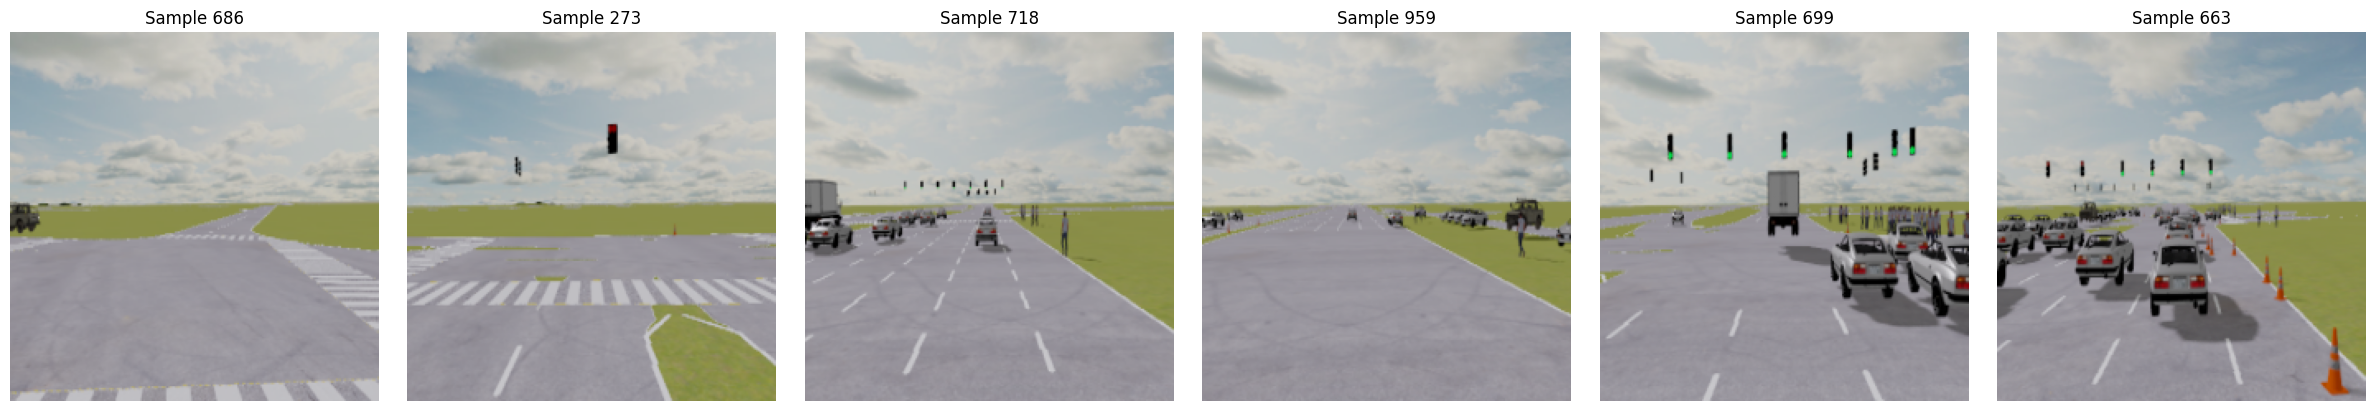

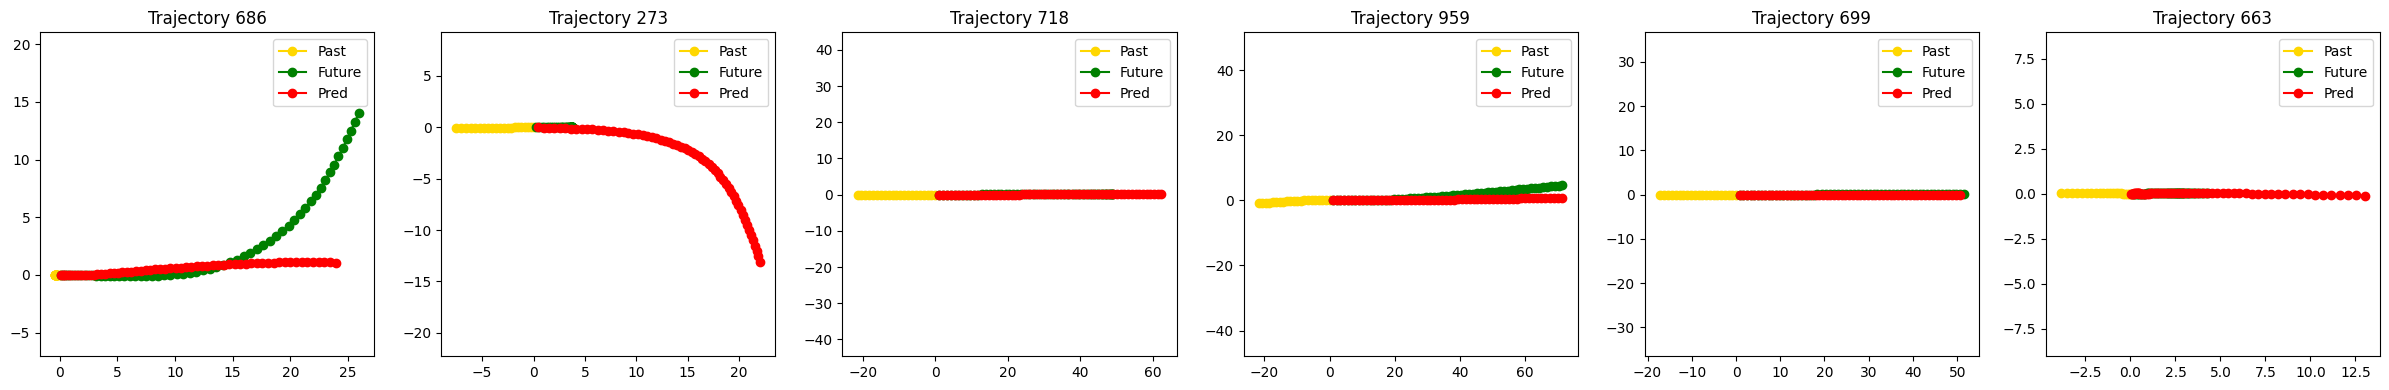

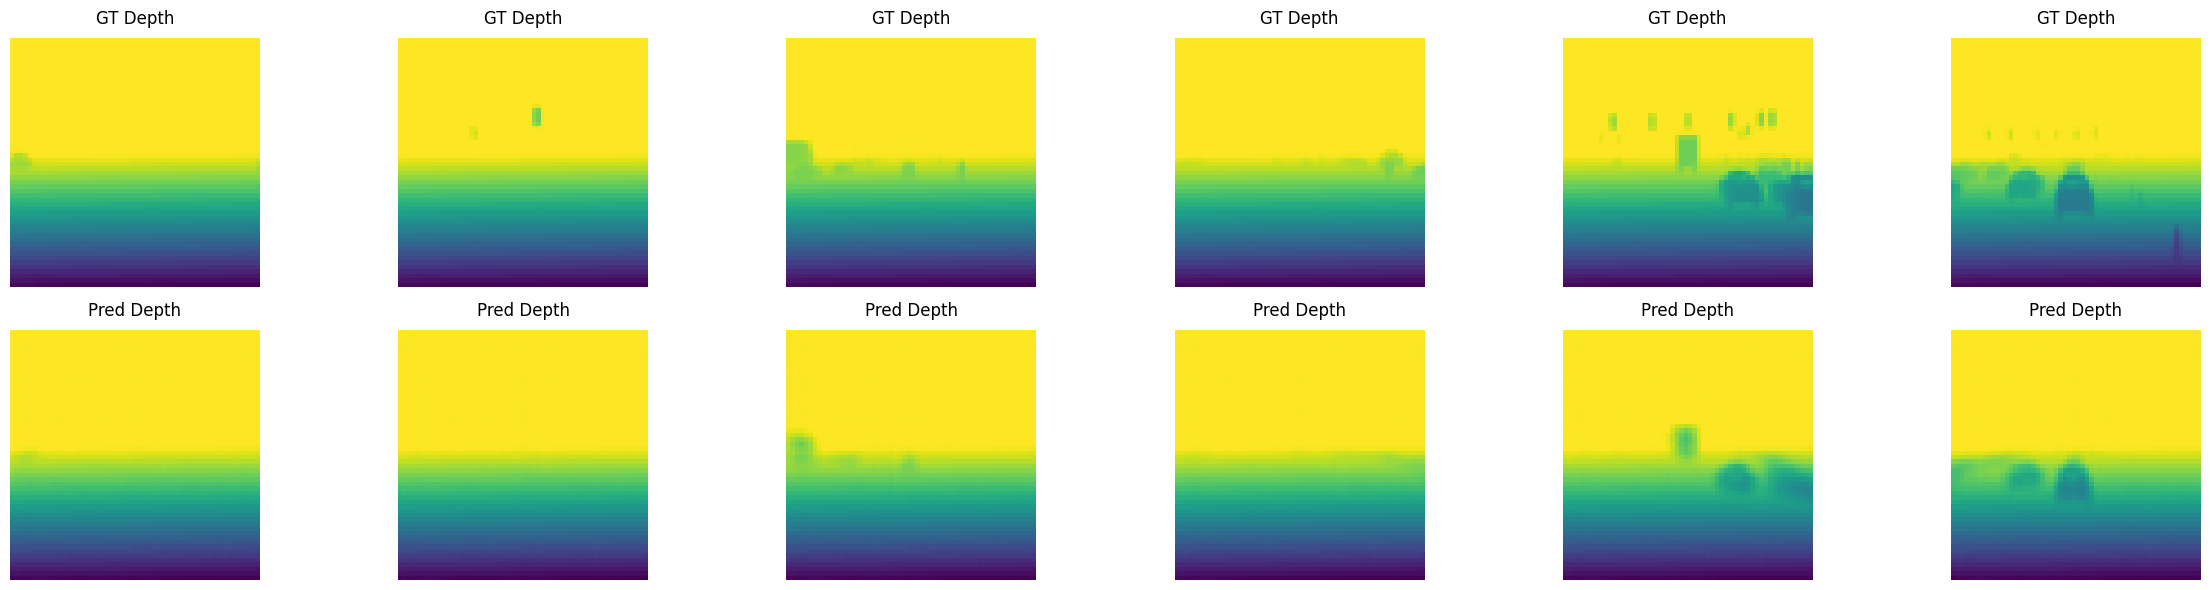

In [164]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load('best_model.pt'))
model.to(device)
model.eval()

all_preds, all_futures, all_histories = [], [], []
all_images, all_depths, all_pred_depths = [], [], []
all_semantics = []
all_lane_masks = []
all_attn_preds = {k: [] for k in model.attn_heads.keys()}  # car, truck, etc

with torch.no_grad():
    for batch in tqdm(val_loader, desc="[Validating Full Set]"):
        camera   = batch["camera"].to(device)
        history  = batch["history"].to(device)
        future   = batch["future"].to(device)
        command  = batch["command"].to(device)
        depth    = batch["depth"].to(device)
        semantic = batch["semantic"].to(device)
        lane_mask = batch["lane_line_mask"].to(device)
        sem_mask = batch["semantic_mask"].to(device)  # 👈 new line

        # === Forward ===
        traj_pred, pred_depth, _, attn_preds = model(
            camera,
            history,
            command,
            depth=depth,
            semantic_mask=sem_mask,  # 👈 new argument
            return_aux=True,
            force_aux=True  # ensure aux is ON
        )

        all_preds.append(traj_pred.cpu())
        all_futures.append(future.cpu())
        all_histories.append(history.cpu())
        all_images.append(camera.cpu())
        all_depths.append(depth.cpu())
        all_pred_depths.append(pred_depth.cpu())
        all_semantics.append(semantic.cpu())
        all_lane_masks.append(lane_mask.cpu())

# Stack
all_preds = torch.cat(all_preds).numpy()
all_futures = torch.cat(all_futures).numpy()
all_histories = torch.cat(all_histories).numpy()
all_images = torch.cat(all_images).numpy()
all_depths = torch.cat(all_depths).numpy()
all_pred_depths = torch.cat(all_pred_depths).numpy()
all_semantics = torch.cat(all_semantics, dim=0).numpy()
all_lane_masks = torch.cat(all_lane_masks, dim=0).numpy()

# Pick samples to visualize
k = 6
selected_indices = random.sample(range(len(all_preds)), k)

# === RGB Images ===
fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
for i, idx in enumerate(selected_indices):
    img = np.clip(all_images[idx].transpose(1, 2, 0), 0, 1)
    axis[i].imshow(img)
    axis[i].axis("off")
    axis[i].set_title(f"Sample {idx}")
plt.tight_layout()
plt.show()

# === Trajectories ===
fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
for i, idx in enumerate(selected_indices):
    ax = axis[i]
    ax.plot(all_histories[idx, :, 0], all_histories[idx, :, 1], "o-", color="gold", label="Past")
    ax.plot(all_futures[idx, :, 0], all_futures[idx, :, 1], "o-", color="green", label="Future")
    ax.plot(all_preds[idx, :, 0], all_preds[idx, :, 1], "o-", color="red", label="Pred")
    ax.axis("equal")
    ax.set_title(f"Trajectory {idx}")
    ax.legend()
plt.tight_layout()
plt.show()

# === Depth Maps ===
vmin = np.percentile(all_depths, 1)
vmax = np.percentile(all_depths, 99)

fig, ax = plt.subplots(2, k, figsize=(4 * k, 6))
for i, idx in enumerate(selected_indices):
    ax[0, i].imshow(all_depths[idx][0], cmap='viridis', vmin=vmin, vmax=vmax)
    ax[0, i].set_title("GT Depth", pad=10)
    ax[0, i].axis("off")

    ax[1, i].imshow(all_pred_depths[idx][0], cmap='viridis', vmin=vmin, vmax=vmax)
    ax[1, i].set_title("Pred Depth", pad=10)
    ax[1, i].axis("off")
plt.tight_layout()
plt.show()


# # === Semantic + Lane Mask Inspection ===
# for i, idx in enumerate(selected_indices):
#     fig, axs = plt.subplots(1, 2, figsize=(10, 4))

#     # Semantic label (class indices)
#     axs[0].imshow(all_semantics[idx], cmap='tab20')
#     axs[0].set_title(f"Semantic Map {idx}")
#     axs[0].axis("off")

#     # Lane mask
#     axs[1].imshow(all_lane_masks[idx], cmap='gray')
#     axs[1].set_title(f"Lane Mask {idx}")
#     axs[1].axis("off")

#     plt.tight_layout()
#     plt.show()

Now we run our model on the test set once, to get the plan of our model and save it for submission. Notice that the ground truth plans are removed for the test set, so you can not calculate the ADE metric on the test set yourself, and need to submit it to the leader board. By running the last cell, you'll be able to see a csv file called `submission_phase1.csv` by clicking on the folder icon on the left. Download it and submit it to the leaderboard to get your score.

In [ ]:
with open(f"test_public/0.pkl", "rb") as f:
    data = pickle.load(f)
print(data.keys())
# Note the absence of sdc_future_feature

dict_keys(['camera', 'depth', 'driving_command', 'sdc_history_feature', 'semantic_label'])


In [ ]:
import pandas as pd

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# === Load test data ===
test_data_dir = "test_public"
test_files = sorted(
    [os.path.join(test_data_dir, fn) for fn in os.listdir(test_data_dir) if fn.endswith(".pkl")],
    key=lambda fn: int(os.path.splitext(os.path.basename(fn))[0])
)
test_dataset = DrivingDataset(test_files, test=True)
test_loader = DataLoader(test_dataset, batch_size=250, num_workers=2)

# === Load Model ===
model.load_state_dict(torch.load('best_model.pt'))
model.to(device)
model.eval()

all_plans = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Running Inference"):
        camera = batch['camera'].to(device)
        history = batch['history'].to(device)
        command = batch['command'].to(device)

        # === Optional: semantic/depth if dataset includes them ===
        if 'semantic_mask' in batch:
            print("Hello")
            semantic_mask = batch['semantic_mask'].to(device)
            depth = batch['depth'].to(device)
            traj_pred = model(
                camera, history, command,
                depth=depth,
                semantic_mask=semantic_mask,
                return_aux=False,
                force_aux=True  # force fusion
            )
        else:
            traj_pred = model(
                camera, history, command,
                return_aux=False,
                force_aux=False
            )

        all_plans.append(traj_pred.cpu().numpy()[..., :2])  # x, y only

# === Flatten Results ===
all_plans = np.concatenate(all_plans, axis=0)  # (N, T, 2)
total_samples, T, D = all_plans.shape
pred_xy_flat = all_plans.reshape(total_samples, T * D)

# === Save CSV ===
ids = np.arange(total_samples)
df_xy = pd.DataFrame(pred_xy_flat)
df_xy.insert(0, "id", ids)

col_names = ["id"] + [f"{coord}_{t}" for t in range(1, T+1) for coord in ['x', 'y']]
df_xy.columns = col_names

df_xy.to_csv("submission_phase1_DC.csv", index=False)
print(f"CSV saved! Shape: {df_xy.shape}")

# === Sanity Check ===
x_cols = [c for c in df_xy.columns if c.startswith("x_")]
y_cols = [c for c in df_xy.columns if c.startswith("y_")]

max_x, min_x = df_xy[x_cols].max().max(), df_xy[x_cols].min().min()
max_y, min_y = df_xy[y_cols].max().max(), df_xy[y_cols].min().min()

print(f" X: [{min_x:.2f}, {max_x:.2f}] | Y: [{min_y:.2f}, {max_y:.2f}]")

Running Inference:  25%|██▌       | 1/4 [00:01<00:04,  1.42s/it]

Hello
Hello


Running Inference:  75%|███████▌  | 3/4 [00:02<00:00,  1.38it/s]

Hello
Hello


Running Inference: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]


✅ CSV saved! Shape: (1000, 121)
🟥 X: [-0.18, 81.67] | 🟦 Y: [-32.95, 25.33]
